# Atividade 7 - Classificador SVM

# PCA

# Algoritmo SVC

SVM:

● Realizar validação cruzada k=10 para testar SVMs utilizando:
    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)

Em cada um, calibrar os parâmetros (kernel, parâmetros do kernel e C) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# PCA
from sklearn.decomposition import PCA

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.svm import SVC # C-Support Vector Classification
from sklearn.svm import LinearSVC # Linear Support Vector Classification
from sklearn.svm import NuSVC # Nu-Support Vector Classification


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


## Pré-Processamento

In [3]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [4]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [5]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [6]:
df_imp = df_processed.copy()

In [7]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## PCA (matriz de correlação)

In [8]:
scaler = preprocessing.StandardScaler()
X_imp = df_imp.drop('Biopsy', axis=1)

X_std = pd.DataFrame(scaler.fit_transform(X_imp) , columns = X_imp.columns.tolist())

#X_std.describe()

In [9]:
pca_corr = PCA()
pca_corr.fit(X_std)

#pd.DataFrame(pca_corr.get_covariance(), columns = df_imp.columns.tolist()).head()

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
autovalores_corr = pca_corr.explained_variance_.tolist()
variancia_corr = pca_corr.explained_variance_ratio_
variancia_acumulada_corr = np.cumsum(variancia_corr.tolist())

print('\tAuto-valores\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada_corr):
    print(num+1,'\t' + '%0.3f' % autovalores_corr[num] + '\t\t' +'%0.3f' %variancia_corr[num],'\t\t\t'+ '%0.2f' %item)

	Auto-valores	Variância explicada	Variância acumulada

1 	5.116		0.155 			0.15
2 	3.028		0.092 			0.25
3 	2.473		0.075 			0.32
4 	2.078		0.063 			0.38
5 	2.017		0.061 			0.45
6 	1.716		0.052 			0.50
7 	1.546		0.047 			0.54
8 	1.361		0.041 			0.59
9 	1.278		0.039 			0.62
10 	1.235		0.037 			0.66
11 	1.064		0.032 			0.69
12 	1.029		0.031 			0.72
13 	1.008		0.031 			0.76
14 	0.935		0.028 			0.78
15 	0.857		0.026 			0.81
16 	0.843		0.026 			0.83
17 	0.811		0.025 			0.86
18 	0.795		0.024 			0.88
19 	0.745		0.023 			0.91
20 	0.654		0.020 			0.93
21 	0.572		0.017 			0.94
22 	0.478		0.014 			0.96
23 	0.320		0.010 			0.97
24 	0.276		0.008 			0.98
25 	0.234		0.007 			0.98
26 	0.175		0.005 			0.99
27 	0.125		0.004 			0.99
28 	0.092		0.003 			0.99
29 	0.076		0.002 			1.00
30 	0.066		0.002 			1.00
31 	0.030		0.001 			1.00
32 	0.008		0.000 			1.00
33 	0.000		0.000 			1.00
34 	0.000		0.000 			1.00
35 	0.000		0.000 			1.00


In [11]:
max_var = []
for num in range(0, len(variancia_corr)):
    if variancia_corr[num] > 0.02: # threshold - queremos variancia mais que 0.02
        max_var.append(num)

best_var = max(max_var)
# +1 porque a tabela acima começa com 1 e nao com 0 
print('{} - {:.3f}'.format(best_var+1,variancia_corr[best_var]))

19 - 0.023


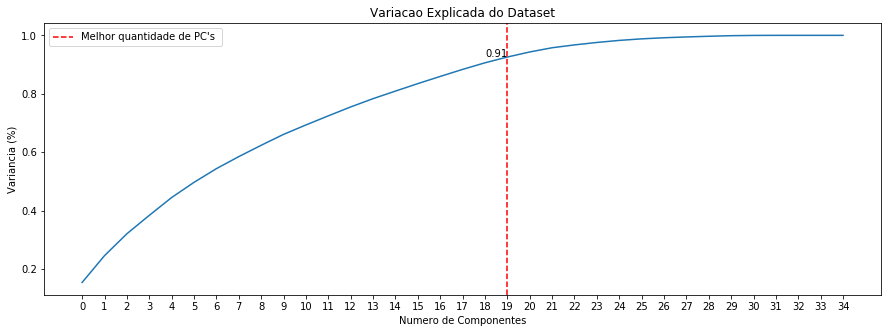

In [12]:
# Plotando o somatório cumulativo da variação explicada
PCA_MinMax = plt.figure(figsize=(15,5))
plt.plot(np.cumsum(variancia_corr))
plt.xlabel('Numero de Componentes')
plt.ylabel('Variancia (%)') #for each component
plt.xticks(range(0,35))
plt.axvline(best_var+1, 0, 1, label='Melhor quantidade de PC\'s ',  color='r', linestyle='--')
plt.legend()
plt.title('Variacao Explicada do Dataset')
plt.annotate('{:.2f}'.format(variancia_acumulada_corr[best_var]),
            xy=(best_var, variancia_acumulada_corr[best_var]+0.02), )
plt.show()

PCA_MinMax.savefig("PCA_MinMax.png", bbox_inches='tight', dpi=600)

In [13]:
numero_pcs = 12

pca_corr = PCA(n_components=numero_pcs)
df_pca = pd.DataFrame(pca_corr.fit_transform(X_std))
df_pca = df_pca.join(df_imp['Biopsy'])

df_pca.head()

0          1          2         3         4         5         6         7         8         9        10        11  Biopsy
0 -0.812803  -1.027645  -0.345563  0.403859  1.066153 -0.094825 -1.246366 -0.118118 -0.513034 -0.150238 -0.645933 -0.043525       0
1 -0.899590  -1.273054  -0.714714  0.460873  1.137792  0.103552 -1.280041  0.105543 -0.572099 -0.068409  0.090972 -0.320480       0
2 -0.815926  -0.654854  -0.485244  0.345858  0.145764 -0.174393 -0.647621  0.852371  0.218327  0.963788 -0.277733 -0.092739       0
3  1.486472  11.660549  10.986786 -3.341629  6.836307 -4.235146  0.029242  2.390350 -0.536513  0.799810  1.055251  0.610696       0
4 -0.630973   0.984704   0.638615 -0.136502 -2.382149 -0.246407  3.190716  0.176686  1.118380  0.334438 -0.081574 -0.063094       0

## Stratified Cross- Validation

### Dataset Desbalanceado

In [14]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    clf = algoritmo(kernel=kernel, gamma=gamma, C=c, verbose=1)
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                        # quantidade de classes dentro da fold
                        count_classes_fold = y.iloc[test_index].value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))

                        # aplica o classificador
                        clf = clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                clf = algoritmo(kernel=kernel, C=c, verbose=1)
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = clf.gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)
                    
                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

### Dataset Balanceado

In [15]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    clf = algoritmo(kernel=kernel, gamma=gamma, C=c, verbose=1)
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
                        
                        # Normaliza MinMax para aplicar Smote
                        X_train_normalized = minmax_scale.fit_transform(X_train)
                        X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())
                        
                        # SMOTETomek (apenas os dados de treino)
                        print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                        X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
                        
                        # Retorna para valores não normalizados
                        X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                        print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                                 y_train.value_counts()[0], 
                                                                                                 y_train.value_counts()[1], 
                                                                                                 ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                                 ((y_train.value_counts()[1]/len(y_train))*100)))

                        # quantidade de classes dentro da fold
                        count_classes_fold = y_test.value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('\t\tDados de teste (desbalanceados)')
                        print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))
                        # aplica o classificador
                        clf = clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                clf = algoritmo(kernel=kernel, C=c, verbose=1)
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = clf.gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # Normaliza MinMax para aplicar Smote
                    X_train_normalized = minmax_scale.fit_transform(X_train)
                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                    # SMOTETomek (apenas os dados de treino)
                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                    # Retorna para valores não normalizados
                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                    print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                             y_train.value_counts()[0], 
                                                                                             y_train.value_counts()[1], 
                                                                                             ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                             ((y_train.value_counts()[1]/len(y_train))*100)))

                    # quantidade de classes dentro da fold
                    count_classes_fold = y_test.value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('\t\tDados de teste (desbalanceados)')
                    print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

## Grid de Parametros para teste

In [16]:
grid_params_all = {'gamma_range': [1e-4, 10e-1],
               'gamma_step': 0.01,
               'kernels': ['linear', 'poly', 'rbf', 'sigmoid'],#, 'precomputed'],
               'C_range': [1, 10, 100, 1000]
              }

grid_params_semi = {'gamma_range': [1e-4, 10e-1],
               'gamma_step': 0.01,
               'kernels': ['linear', 'rbf', 'sigmoid'],#, 'precomputed'],
               'C_range': [1, 10, 100, 1000]
              }

grid_params_linear = {'kernels': ['linear'],
                      'C_range': [1, 10, 100, 1000]
                     }


grid_params_sigmoid = {'kernels': ['sigmoid'],
                      'gamma_range': [1e-4, 10e-1],
                       'gamma_step': 0.01,
                        'C_range': [1, 10, 100, 1000]
                       }


grid_params_rbf = {'gamma_range': [1e-4, 10e-1],
                   'gamma_step': 0.01,
                   'kernels': ['rbf'],
                   'C_range': [1, 10, 100, 1000]
                   }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> SVC

### Dataset Desbalanceado

In [17]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_pca, k, SVC, random_state, grid_params_semi, shuffle=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Num

In [18]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-PCA_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.666667  0.800000  0.965116       SVC
1  linear  1  scale     2   0.800000  0.800000  0.976744       SVC
2  linear  1  scale     3   0.666667  0.800000  0.965116       SVC
3  linear  1  scale     4   1.000000  0.833333  0.988372       SVC
4  linear  1  scale     5   0.428571  0.500000  0.918605       SVC

### Dataset Balanceado

In [19]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_pca, k, SVC, random_state, grid_params_semi, shuffle=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 722 positivas e 722 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 722 positivas e 722 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 8

In [20]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-PCA_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.625000  1.000000  0.965116       SVC
1  linear  1  scale     2   0.666667  0.800000  0.965116       SVC
2  linear  1  scale     3   0.363636  0.800000  0.906977       SVC
3  linear  1  scale     4   0.857143  1.000000  0.988372       SVC
4  linear  1  scale     5   0.363636  0.666667  0.895349       SVC

## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [21]:
mean_unbalanced = scores_unbalanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.781190  0.656667  0.963871
        10   scale                  0.781190  0.656667  0.963871
        100  scale                  0.781190  0.656667  0.963871
        1000 scale                  0.781190  0.640000  0.962709
rbf     1    0.0001                 0.000000  0.000000  0.935910
             0.0101                 0.796667  0.603333  0.962722
             0.0201                 0.786667  0.566667  0.960397
             0.0301                 0.756667  0.526667  0.958071
             0.040100000000000004   0.706667  0.473333  0.954583
             0.050100000000000006   0.656667  0.433333  0.949904
             0.0601                 0.656667  0.416667  0.948741
             0.07010000000000001    0.640000  0.396667  0.947579
             0.0801                 0.640000  0.396667  0.947579
             0.0901                 0.580000  0.360000  0.945253
             0.10010000000000001    0.580000  0.360000  0.945253
             0.1101                 0.580000  0.360000  0.945253
             0.1201                 0.580000  0.340000  0.944077
             0.1301                 0.580000  0.323333  0.942914
             0.1401                 0.575000  0.306667  0.941751
             0.15009999999999998    0.475000  0.270000  0.939412
             0.1601                 0.491667  0.253333  0.940575
             0.1701                 0.491667  0.253333  0.940575
             0.18009999999999998    0.491667  0.253333  0.940575
             0.1901                 0.491667  0.236667  0.939412
             0.2001                 0.541667  0.220000  0.939412
             0.21009999999999998    0.541667  0.220000  0.939412
             0.2201                 0.541667  0.220000  0.939412
             0.2301                 0.533333  0.200000  0.939412
             0.24009999999999998    0.633333  0.220000  0.940588
             0.2501                 0.633333  0.220000  0.940588
             0.2601                 0.633333  0.220000  0.940588
             0.2701                 0.633333  0.220000  0.940588
             0.2801                 0.616667  0.200000  0.939412
             0.29009999999999997    0.666667  0.216667  0.940575
             0.3001                 0.566667  0.200000  0.939412
             0.3101                 0.566667  0.200000  0.939412
             0.3201                 0.566667  0.200000  0.939412
             0.3301                 0.566667  0.200000  0.939412
             0.3401                 0.575000  0.200000  0.940575
             0.3501                 0.475000  0.180000  0.939412
             0.3601                 0.475000  0.180000  0.939412
             0.3701                 0.475000  0.180000  0.939412
             0.3801                 0.475000  0.180000  0.939412
             0.3901                 0.425000  0.160000  0.938235
             0.4001                 0.416667  0.143333  0.937073
             0.4101                 0.416667  0.143333  0.937073
             0.4201                 0.416667  0.143333  0.937073
             0.4301                 0.416667  0.143333  0.937073
             0.4401                 0.433333  0.143333  0.938235
             0.4501                 0.433333  0.143333  0.938235
             0.4601                 0.433333  0.143333  0.938235
             0.4701                 0.433333  0.143333  0.938235
             0.48009999999999997    0.466667  0.143333  0.939398
             0.4901                 0.466667  0.143333  0.939398
             0.5001                 0.466667  0.143333  0.939398
             0.5101                 0.466667  0.143333  0.939398
             0.5201                 0.466667  0.143333  0.939398
             0.5301                 0.366667  0.110000  0.937073
             0.5401                 0.366667  0.110000  0.937073
             0.5501                 0.366667  0.110000  0.937073
     

In [22]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                
rbf     100  0.0001   0.799524  0.640000  0.963899
        1000 0.0001   0.781190  0.660000  0.963885
linear  1    scale    0.781190  0.656667  0.963871
sigmoid 1000 0.0001   0.781190  0.656667  0.963871
linear  100  scale    0.781190  0.656667  0.963871

('rbf', 100, '0.0001')

### Dataset Balanceado

In [23]:
mean_balanced = scores_balanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.525175  0.866667  0.931204
        10   scale                  0.525175  0.866667  0.931204
        100  scale                  0.525175  0.866667  0.931204
        1000 scale                  0.528811  0.866667  0.932367
rbf     1    0.0001                 0.709643  0.716667  0.956908
             0.0101                 0.544544  0.850000  0.937031
             0.0201                 0.577994  0.833333  0.942873
             0.0301                 0.561328  0.793333  0.940547
             0.040100000000000004   0.551111  0.756667  0.938222
             0.050100000000000006   0.541074  0.720000  0.937059
             0.0601                 0.544466  0.703333  0.939398
             0.07010000000000001    0.527500  0.650000  0.937073
             0.0801                 0.537024  0.650000  0.939412
             0.0901                 0.527024  0.630000  0.938249
             0.10010000000000001    0.527024  0.630000  0.938249
             0.1101                 0.524802  0.613333  0.938249
             0.1201                 0.523016  0.593333  0.938235
             0.1301                 0.518016  0.553333  0.937059
             0.1401                 0.518016  0.553333  0.937059
             0.15009999999999998    0.518016  0.553333  0.937059
             0.1601                 0.528333  0.553333  0.939384
             0.1701                 0.531746  0.520000  0.938222
             0.18009999999999998    0.531746  0.520000  0.938222
             0.1901                 0.538690  0.520000  0.939384
             0.2001                 0.522024  0.500000  0.938222
             0.21009999999999998    0.522024  0.500000  0.938222
             0.2201                 0.526786  0.500000  0.939398
             0.2301                 0.521429  0.483333  0.938235
             0.24009999999999998    0.531429  0.483333  0.939398
             0.2501                 0.538095  0.483333  0.940575
             0.2601                 0.538095  0.483333  0.940575
             0.2701                 0.533333  0.466667  0.939412
             0.2801                 0.540000  0.466667  0.940575
             0.29009999999999997    0.540000  0.466667  0.940575
             0.3001                 0.504643  0.450000  0.937073
             0.3101                 0.494643  0.430000  0.935896
             0.3201                 0.494643  0.430000  0.935896
             0.3301                 0.519643  0.430000  0.937059
             0.3401                 0.519643  0.430000  0.937059
             0.3501                 0.532143  0.430000  0.937059
             0.3601                 0.515476  0.430000  0.935896
             0.3701                 0.515476  0.430000  0.935896
             0.3801                 0.515476  0.430000  0.935896
             0.3901                 0.515476  0.430000  0.935896
             0.4001                 0.505476  0.430000  0.935896
             0.4101                 0.505476  0.430000  0.935896
             0.4201                 0.505476  0.430000  0.935896
             0.4301                 0.505476  0.430000  0.935896
             0.4401                 0.505476  0.430000  0.935896
             0.4501                 0.505476  0.430000  0.935896
             0.4601                 0.505476  0.430000  0.935896
             0.4701                 0.505476  0.430000  0.935896
             0.48009999999999997    0.505476  0.430000  0.935896
             0.4901                 0.505476  0.430000  0.935896
             0.5001                 0.548810  0.413333  0.935896
             0.5101                 0.548810  0.413333  0.935896
             0.5201                 0.565476  0.413333  0.937073
             0.5301                 0.565476  0.413333  0.937073
             0.5401                 0.565476  0.413333  0.937073
             0.5501                 0.573810  0.413333  0.938235
     

In [24]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision    Recall  Accuracy
Kernel  c  Gamma                                
sigmoid 1  0.0001   0.713810  0.716667  0.958057
rbf     1  0.0001   0.709643  0.716667  0.956908
sigmoid 10 0.0001   0.579098  0.800000  0.944008
rbf     10 0.0101   0.574618  0.796667  0.942886
        1  scale    0.577994  0.833333  0.942873

('sigmoid', 1, '0.0001')

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [25]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['Kernel'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['c'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['Gamma'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.964, IC = [0.948, 0.980]
Recall: Média = 0.640, IC = [0.531, 0.749]
Precisão: Média = 0.800, IC = [0.633, 0.966]


### Dataset Balanceado

In [26]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Kernel'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['c'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Gamma'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.958, IC = [0.938, 0.978]
Recall: Média = 0.717, IC = [0.578, 0.855]
Precisão: Média = 0.714, IC = [0.527, 0.901]


## Gráfico

In [27]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

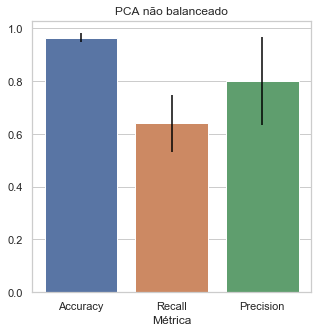

In [28]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('PCA não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('PCA nao balanceado - SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

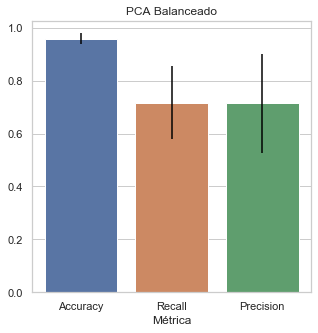

In [29]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('PCA Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('PCA balanceado - SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [31]:
path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '7',
    'SVC',
    'PCA Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    '7',
    'SVC',
    'PCA Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value']
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

Atividade Algoritmo                                          Condicao         Melhores_Params    Metrica     Valor
0          7       SVC  Dataset Completo Desbalanceado - Nao Normalizado  ('linear', 1, 'scale')   Accuracy  0.960383
1          7       SVC  Dataset Completo Desbalanceado - Nao Normalizado  ('linear', 1, 'scale')     Recall      0.86
2          7       SVC  Dataset Completo Desbalanceado - Nao Normalizado  ('linear', 1, 'scale')  Precision  0.677579
3          7       SVC     Dataset Completo Balanceado - Nao Normalizado  ('rbf', 100, '0.0001')   Accuracy  0.962709
4          7       SVC     Dataset Completo Balanceado - Nao Normalizado  ('rbf', 100, '0.0001')     Recall  0.876667
5          7       SVC     Dataset Completo Balanceado - Nao Normalizado  ('rbf', 100, '0.0001')  Precision  0.690079
6          7       SVC      Dataset Completo Desbalanceado - Normalizado  ('rbf', 100, '0.0001')   Accuracy  0.962709
7          7       SVC      Dataset Completo Desbalanceado - Normalizado  ('rbf', 100, '0.0001')     Recall  0.876667
8          7       SVC      Dataset Completo Desbalanceado - Normalizado  ('rbf', 100, '0.0001')  Precision  0.690079
9          7       SVC         Dataset Completo Balanceado - Normalizado  ('rbf', 100, '0.0001')   Accuracy  0.959193
10         7       SVC         Dataset Completo Balanceado - Normalizado  ('rbf', 100, '0.0001')     Recall      0.91
11         7       SVC         Dataset Completo Balanceado - Normalizado  ('rbf', 100, '0.0001')  Precision  0.673016
12         7       SVC                                 PCA Desbalanceado      (rbf, 100, 0.0001)   Accuracy  0.963899
13         7       SVC                                 PCA Desbalanceado      (rbf, 100, 0.0001)     Recall      0.64
14         7       SVC                                 PCA Desbalanceado      (rbf, 100, 0.0001)  Precision  0.799524
15         7       SVC                                    PCA Balanceado    (sigmoid, 1, 0.0001)   Accuracy  0.958057
16         7       SVC                                    PCA Balanceado    (sigmoid, 1, 0.0001)     Recall  0.716667
17         7       SVC                                    PCA Balanceado    (sigmoid, 1, 0.0001)  Precision   0.71381

Resultados salvos com sucesso
